<a href="https://colab.research.google.com/github/KrisNguyen135/Deep-Learning-with-Google-Colab/blob/master/notebooks/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

os.environ['KAGGLE_USERNAME'] = '###########'
os.environ['KAGGLE_KEY'] = '################'

!kaggle competitions download -c dogs-vs-cats
!unzip -q train.zip

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 34.6MB/s]
 98% 265M/271M [00:06<00:00, 25.0MB/s]
100% 271M/271M [00:06<00:00, 42.5MB/s]
 98% 530M/543M [00:11<00:00, 60.0MB/s]
100% 543M/543M [00:11<00:00, 49.0MB/s]


In [0]:
import torch
import torchvision
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import time
import shutil
import random; random.seed(0)

In [0]:
if torch.cuda.is_available():
    print('CUDA is available. Using the GPU.')
    device = torch.device('cuda')
else:
    print('CUDA is not available. Using the CPU.')
    device = torch.device('cpu')

CUDA is available. Using the GPU.


In [0]:
labels = ['cat', 'dog']

train_directory = './train'
val_directory = './val'

try:
    os.mkdir(val_directory)
except FileExistsError:
    pass

for label in labels:    
    # Create the subfolders.
    try:
        os.mkdir(os.path.join(train_directory, label))
        os.mkdir(os.path.join(val_directory, label))
    except FileExistsError:
        pass
    
    # Move all files to subfolders.
    filenames = [filename for filename in os.listdir(train_directory)
                 if filename.startswith(label) 
                 and os.path.isfile(os.path.join(train_directory, filename))]
    
    for file in filenames:        
        shutil.move(
            os.path.join(train_directory, file),
            os.path.join(train_directory, label, file)
        )
    
    # Move validation files to subfolders.
    val_filenames = random.sample(filenames, len(filenames) // 5)
    
    for file in val_filenames:
        shutil.move(
            os.path.join(train_directory, label, file),
            os.path.join(val_directory, label, file)
        )

In [0]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.dataset = torchvision.datasets.ImageFolder(
            self.directory,
            transform=transform,
            loader=self.__load_image
        )
        
    def __len__(self):
        return len(self.dataset)
    
    def __load_image(self, path):
        img = cv2.imread(path)
        img = Image.fromarray(img)
        
        return img
    
    def __getitem__(self, idx):
        return self.dataset[idx]

In [0]:
train_dataset = ImageDataset(train_directory)
val_dataset = ImageDataset(val_directory)

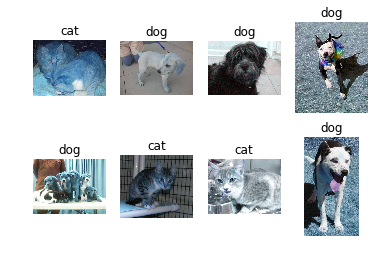

In [0]:
n_img = 8

for i in range(n_img // 2):
    plt.subplot(2, 4, i + 1)
    img, label = train_dataset[random.randint(0, len(train_dataset) - 1)]
    plt.imshow(img)
    plt.title(train_dataset.dataset.classes[label])
    plt.axis('off')

for i in range(n_img // 2):
    plt.subplot(2, 4, n_img // 2 + i + 1)
    img, label = val_dataset[random.randint(0, len(val_dataset) - 1)]
    plt.imshow(img)
    plt.title(val_dataset.dataset.classes[label])
    plt.axis('off')

plt.show()

In [0]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(train_directory, transform=train_transforms)
val_dataset = ImageDataset(val_directory, transform=val_transforms)

In [0]:
batch_size = 128  # to be changed 128

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [0]:
def show_grid(images, labels):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    grid = torchvision.utils.make_grid(images)
    
    plt.imshow((grid.numpy().transpose((1, 2, 0))) * std + mean)
    plt.title(labels.numpy())
    plt.axis('off')
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


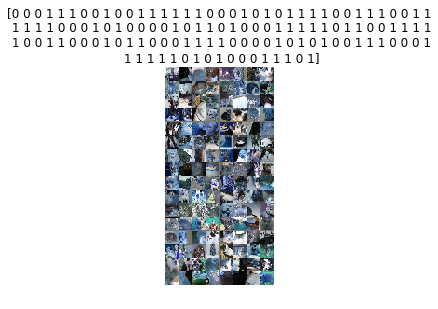

In [0]:
images, labels = next(iter(train_loader))
show_grid(images, labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


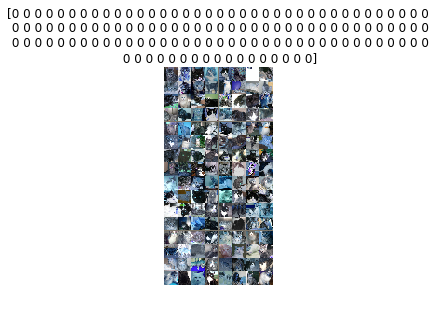

In [0]:
images, labels = next(iter(val_loader))
show_grid(images, labels)

In [0]:
model = torchvision.models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 178272643.60it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
n_features = model.fc.in_features
model.fc = torch.nn.Linear(n_features, 2)
model = model.to(device)

n_epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [0]:
model.train()

start = time.time()
epoch_losses = []

for epoch in range(n_epochs):
    running_loss = 0
    
    for i, (images, labels) in enumerate(train_loader):
        # Send data to the GPU.
        images = images.to(device)
        labels = labels.to(device)
        
        # Predicting and backpropagation.
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        # Performance statistics.
        running_loss += loss.item() * images.size(0)
        
    temp_epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(temp_epoch_loss)
    print(f'Epoch {epoch + 1}/{n_epochs}: {temp_epoch_loss:.4f}')
    
time_elapsed = time.time() - start
print(f'Training finished in {time_elapsed // 60:.0f}m {time_elapsed % 60:.4f}s')

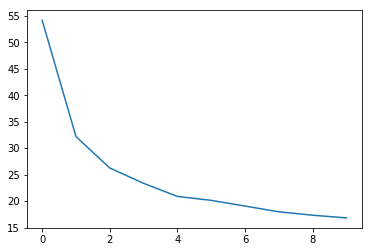

In [0]:
plt.plot(epoch_losses)
plt.show()

In [0]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    
    print(f'Accuracy: {100 * correct / total}%')

Accuracy: 98.18%
